In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
%matplotlib inline
sns.set_style('darkgrid')

In [9]:
data = pd.read_csv(
    "data/processed/MSFT_3mo_processed.csv", parse_dates=["Date"], index_col="Date"
)
data.head()
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2024-07-29 00:00:00-04:00 to 2024-10-08 00:00:00-04:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          51 non-null     float64
 1   High          51 non-null     float64
 2   Low           51 non-null     float64
 3   Close         51 non-null     float64
 4   Volume        51 non-null     int64  
 5   Dividends     51 non-null     float64
 6   Stock Splits  51 non-null     float64
 7   SMA_5         51 non-null     float64
 8   RSI           51 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 4.0 KB


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
SMA_5           0
RSI             0
dtype: int64

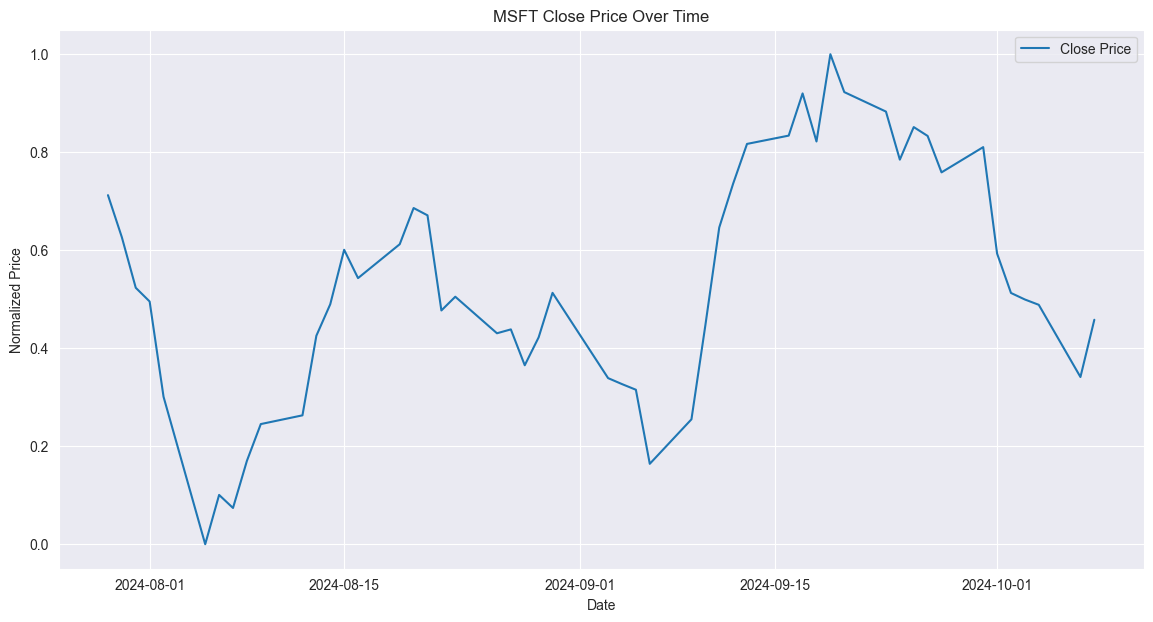

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(data["Close"], label="Close Price")
plt.title("MSFT Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

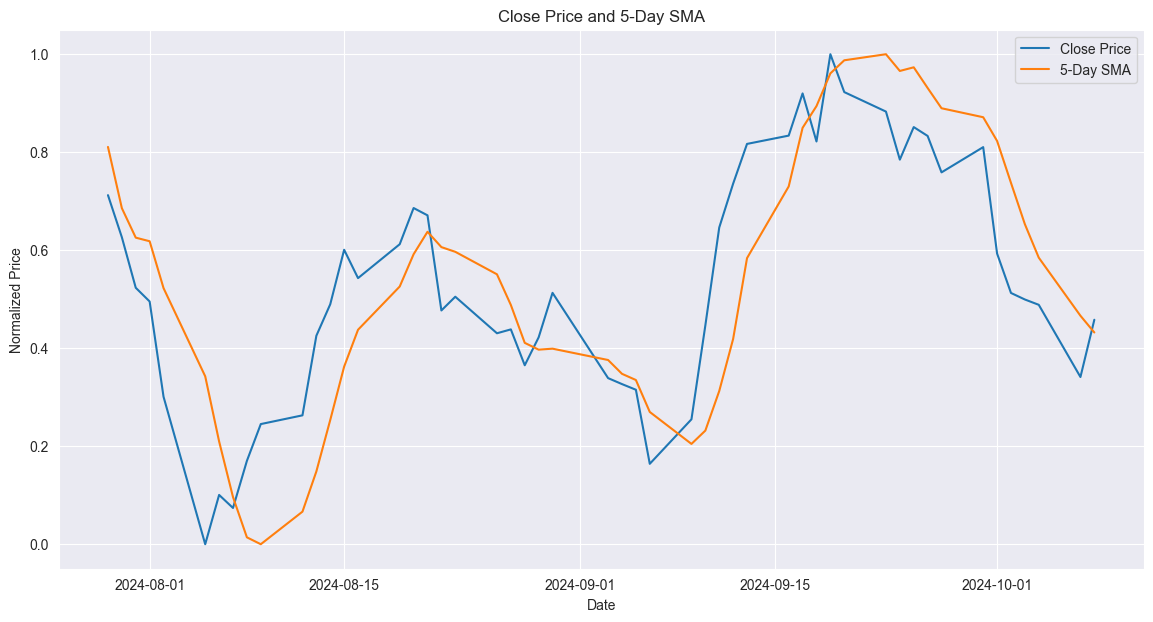

In [13]:
# Plot SMA
plt.figure(figsize=(14, 7))
plt.plot(data["Close"], label="Close Price")
plt.plot(data["SMA_5"], label="5-Day SMA")
plt.title("Close Price and 5-Day SMA")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

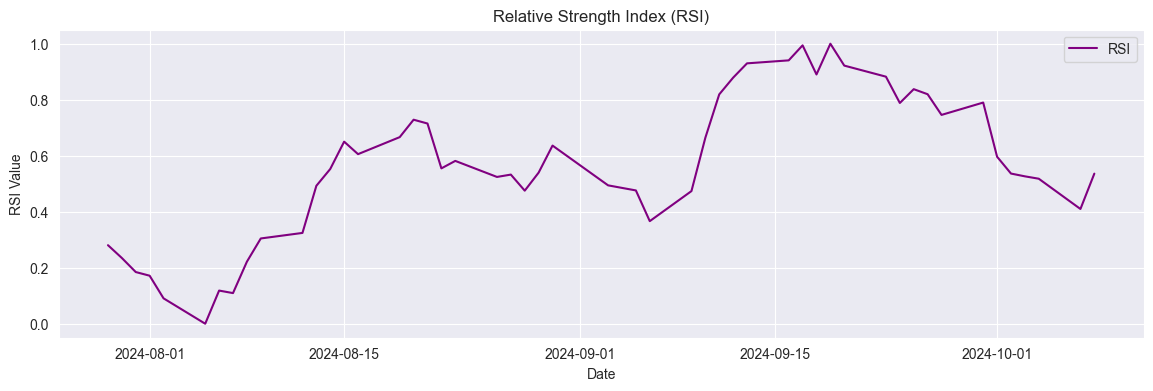

In [14]:
# Plot RSI
plt.figure(figsize=(14, 4))
plt.plot(data["RSI"], label="RSI", color="purple")
plt.title("Relative Strength Index (RSI)")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.show()

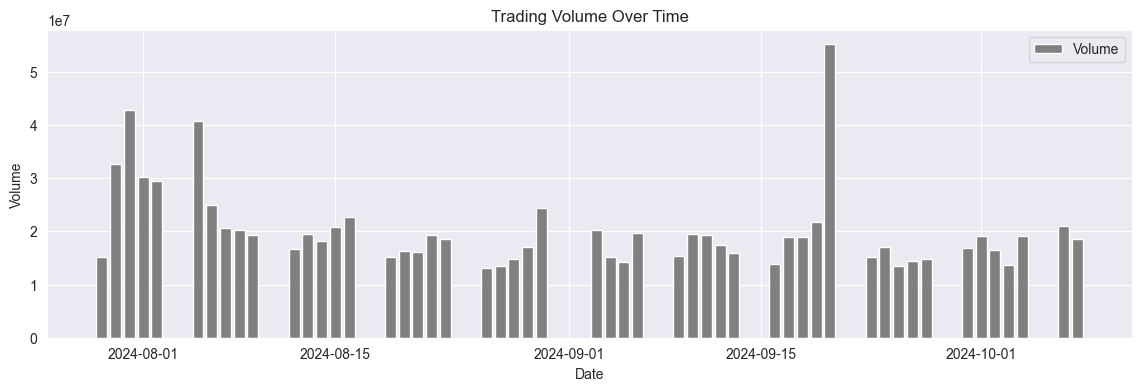

In [15]:
plt.figure(figsize=(14, 4))
plt.bar(data.index, data["Volume"], label="Volume", color="gray")
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()